In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000115 (2).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000115 (5).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000112.png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000118 (5).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000117 (4).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000114 (6).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000117 (6).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000114 (4).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000118 (4).png
/kaggle/input/chest-cts

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    
    # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [4]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

In [5]:
# Get Dataframes
train_dir = '../input/chest-ctscan-images/Data/train'
test_dir = '../input/chest-ctscan-images/Data/valid'
valid_dir = '../input/chest-ctscan-images/Data/test'
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)


Found 613 validated image filenames belonging to 4 classes.
Found 315 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.


In [6]:
train_df

,filepaths,labels
0,../input/chest-ctscan-images/Data/train/squamo...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
1,../input/chest-ctscan-images/Data/train/squamo...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
2,../input/chest-ctscan-images/Data/train/squamo...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
3,../input/chest-ctscan-images/Data/train/squamo...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
4,../input/chest-ctscan-images/Data/train/squamo...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
...,...,...
608,../input/chest-ctscan-images/Data/train/adenoc...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
609,../input/chest-ctscan-images/Data/train/adenoc...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
610,../input/chest-ctscan-images/Data/train/adenoc...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
611,../input/chest-ctscan-images/Data/train/adenoc...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)


43941136/43941136 [==============================] - 2s 0us/step
Epoch 1/100


2024-03-18 19:18:56.979381: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


16/16 [==============================] - ETA: 0s - loss: 1.2310 - accuracy: 0.5693
Epoch 1: val_accuracy improved from -inf to 0.64127, saving model to best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 29s 1s/step - loss: 1.2310 - accuracy: 0.5693 - val_loss: 1.3750 - val_accuracy: 0.6413
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.7635
Epoch 2: val_accuracy improved from 0.64127 to 0.66984, saving model to best_model.h5
16/16 [==============================] - 7s 450ms/step - loss: 0.6232 - accuracy: 0.7635 - val_loss: 1.2455 - val_accuracy: 0.6698
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.3551 - accuracy: 0.8695
Epoch 3: val_accuracy did not improve from 0.66984
16/16 [==============================] - 6s 387ms/step - loss: 0.3551 - accuracy: 0.8695 - val_loss: 1.2832 - val_accuracy: 0.6698
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.3397 - accuracy: 0.8679
Epoch 4: val_accuracy did not improve from 0.66984
16/16 [==============================] - 6s 385ms/step - loss: 0.3397 - accuracy: 0.8679 - val_loss: 1.0797 - val_accuracy: 0.6635
Epoch

In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 2s 2s/step - loss: 0.4881 - accuracy: 0.8889
Train Loss:  3.0680712370667607e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  0.7814599275588989
Validation Accuracy:  0.824999988079071
--------------------
Test Loss:  0.48809894919395447
Test Accuracy:  0.8888888955116272


In [9]:
from tensorflow.keras.applications import ResNet50

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained ResNet50 model
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = Adam()  # Using Adam optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_resnet.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)


94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.9534 - accuracy: 0.6754
Epoch 1: val_accuracy improved from -inf to 0.39048, saving model to best_model_resnet.h5
16/16 [==============================] - 14s 532ms/step - loss: 0.9534 - accuracy: 0.6754 - val_loss: 4.3739 - val_accuracy: 0.3905
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.2199 - accuracy: 0.9331
Epoch 2: val_accuracy improved from 0.39048 to 0.67937, saving model to best_model_resnet.h5
16/16 [==============================] - 7s 427ms/step - loss: 0.2199 - accuracy: 0.9331 - val_loss: 1.4574 - val_accuracy: 0.6794
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9657
Epoch 3: val_accuracy improved from 0.67937 to 0.72063, saving model to best_model_resnet.h5
16/16 [==============================] - 7s 454ms/step - loss: 0.1273 - accuracy: 0.9657 - val_loss: 1.4473 - v

In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_resnet.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 2s 2s/step - loss: 0.8030 - accuracy: 0.9028
Train Loss:  0.0003485982888378203
Train Accuracy:  1.0
--------------------
Validation Loss:  2.186516761779785
Validation Accuracy:  0.75
--------------------
Test Loss:  0.8030182719230652
Test Accuracy:  0.9027777910232544


In [11]:
from tensorflow.keras.applications import InceptionV3
# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained InceptionV3 model
base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = Adam()  # Using Adam optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_inceptionv3.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)


87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 1.6598 - accuracy: 0.5465
Epoch 1: val_accuracy improved from -inf to 0.22222, saving model to best_model_inceptionv3.h5
16/16 [==============================] - 16s 622ms/step - loss: 1.6598 - accuracy: 0.5465 - val_loss: 14.8089 - val_accuracy: 0.2222
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.9663 - accuracy: 0.6672
Epoch 2: val_accuracy improved from 0.22222 to 0.46667, saving model to best_model_inceptionv3.h5
16/16 [==============================] - 7s 455ms/step - loss: 0.9663 - accuracy: 0.6672 - val_loss: 7.9647 - val_accuracy: 0.4667
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.8395 - accuracy: 0.7178
Epoch 3: val_accuracy did not improve from 0.46667
16/16 [==============================] - 6s 400ms/step - loss: 0.8395 - accuracy: 0.7178 - val_loss: 12.7819 - val_accuracy: 0.1778
Epoch 4/10

In [12]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_inceptionv3.h5')


ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 2s 2s/step - loss: 0.8950 - accuracy: 0.7083
Train Loss:  0.03253987804055214
Train Accuracy:  1.0
--------------------
Validation Loss:  1.3791110515594482
Validation Accuracy:  0.5249999761581421
--------------------
Test Loss:  0.8950320482254028
Test Accuracy:  0.7083333134651184


In [13]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

input_shape=img_shape

model_inceptionv3 = load_model('best_model_inceptionv3.h5')
model = load_model('best_model.h5')
model_resnet = load_model('best_model_resnet.h5')

# Create input layer
input_layer = Input(shape=(input_shape))  # Replace input_shape with the appropriate shape for your models

# Get outputs from all three models
output_inceptionv3 = model_inceptionv3(input_layer)
output_model = model(input_layer)
output_resnet = model_resnet(input_layer)

# Average the predictions from all three models
average = Average()([output_inceptionv3, output_model, output_resnet])

# Create an ensemble model
ensemble_model = Model(inputs=input_layer, outputs=average)

# Save the ensemble model
ensemble_model.save('final_ensemble_model.h5')

In [14]:
model = load_model('final_ensemble_model.h5')
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

/tmp/ipykernel_26/2064879440.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 0 2 2 2 1 0 0 1 1 1 1 0 1
 1 1 1 3 1 0 1 1 1 1 1 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]


In [15]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('final_ensemble_model.h5')

# Compile the model
# Replace 'optimizer' and 'loss' with your chosen optimizer and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming you've defined test_gen and test_df
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Evaluate the model
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])


1/1 [==============================] - 9s 9s/step - loss: 0.2533 - accuracy: 0.8750
Test Loss: 0.2532910406589508
Test Accuracy: 0.875


In [16]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[21  0  0  2]
 [ 4 16  0  1]
 [ 1  0 12  0]
 [ 1  0  0 14]]
                         precision    recall  f1-score   support

         adenocarcinoma       0.78      0.91      0.84        23
   large-cell-carcinoma       1.00      0.76      0.86        21
                 normal       1.00      0.92      0.96        13
squamous-cell-carcinoma       0.82      0.93      0.87        15

               accuracy                           0.88        72
              macro avg       0.90      0.88      0.88        72
           weighted avg       0.89      0.88      0.88        72



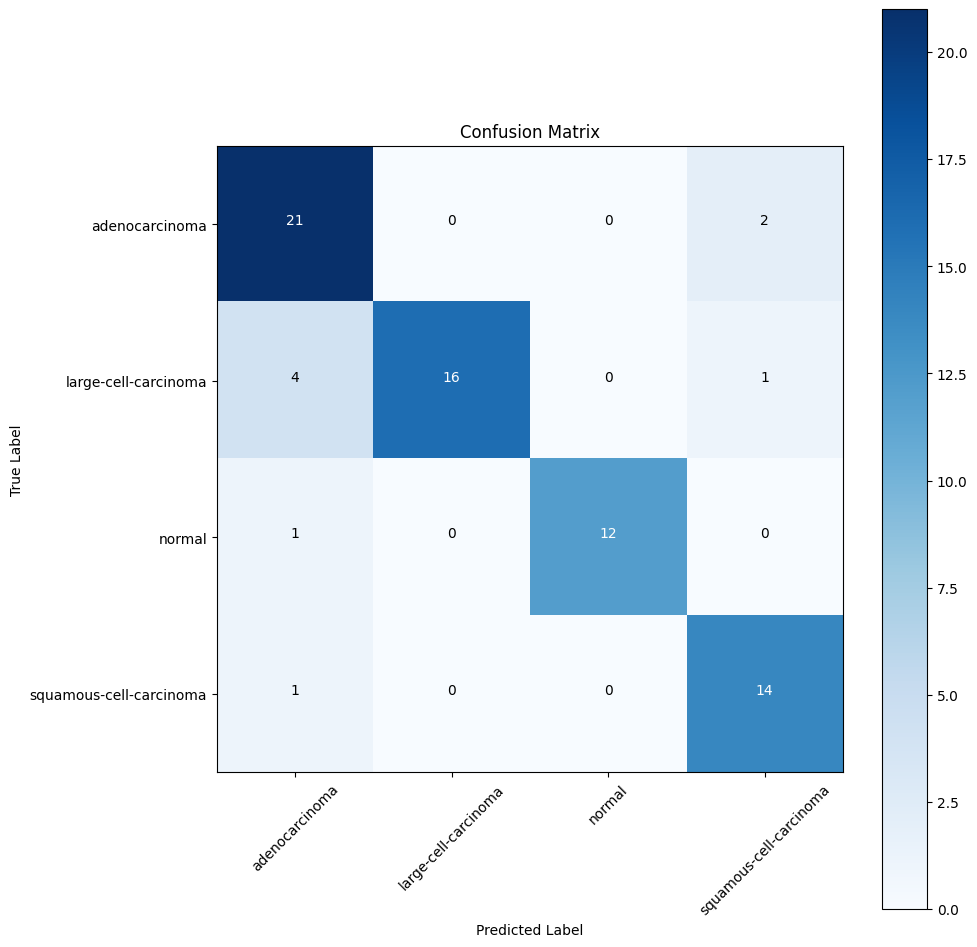

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

target_names = ['adenocarcinoma', 'large-cell-carcinoma', 'normal', 'squamous-cell-carcinoma']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))